### Setup

In [1]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [159]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from irrep_bounds import *
from bound_utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
t.manual_seed(42)    # clustering depends on random seed
np.random.seed(42)

In [4]:
t.set_grad_enabled(False)

In [5]:

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# MODEL_DIR = '2024-08-14_21-24-30_gapS_5_'
MODEL_DIR = '2024-09-18_23-59-00_gapS5_MLP2_128_wd2e-4_ubias'
# MODEL_DIR = '2024-09-22_22-12-21_gapF11_MLP2_256_wd1e-4_ubias'
# MODEL_DIR = '2024-09-23_01-06-18_A5x2_MLP2_128_wd1e-4_ubias'
# MODEL_DIR = '2024-09-23_02-50-16_sg96_227_MLP2_128_wd1e-4_ubias'

disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir,) #sel='final')
models = models[-1]  # get last checkpoint
data = GroupData(params)
group = data.groups[0]

/home/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: gapS(5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


In [162]:
save = t.load('../data/acc_bound_S5_new.pt')
locals().update(save)

/tmp/ipykernel_12705/3089656520.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save = t.load('../data/acc_bound_S5_new.pt')


In [45]:
irrep_idxs = []
for instance in tqdm(range(len(models))):
    model = models[instance]
    irreps, irrep_idx_dict = get_neuron_irreps(model, group, norm_thresh=1)
    irrep_idxs.append(irrep_idx_dict)

100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


In [41]:
ideal_models = MLP2.stack(ideal_models)

In [65]:
def model_subidx(model, idxs):
    if not isinstance(model, MLP4):
        model = model.fold_linear()
    ln, rn, un = model.get_neurons()
    ln, rn, un = ln[:,:,idxs], rn[:,:,idxs], un[:,:,idxs]
    ret = MLP4(model.params)
    ret.embedding_left = nn.Parameter(ln.clone())
    ret.embedding_right = nn.Parameter(rn.clone())
    ret.unembedding = nn.Parameter(un.clone().mT)
    ret.unembed_bias = nn.Parameter(model.unembed_bias.clone())
    return ret

In [166]:
def equivariance(models, group):
    N = len(group)
    models = models.to(device)
    test_inputs = t.tensor(list(product(range(N), repeat=2)), device=device)
    output = models(test_inputs)
    stds = []
    for i in range(N):
        logit_vals = []
        for j, k in product(range(N), repeat=2):
            if group.mult_idx(j, k) == i:
                # output is (N^2, instance, N)
                logit_vals.append(output[N * j + k, :, i])
        logit_vals = t.stack(logit_vals, dim=1)  # (instance, N)
        stds.append(logit_vals.std(dim=1) / (logit_vals.mean(dim=1).abs()))   # (instance)
        # stds.append(logit_vals.var(dim=1))   # (instance)
    stds = t.stack(stds, dim=1)  # (instance, N)
    return stds.mean(dim=1).nan_to_num(0)

In [167]:
orig_equi = equivariance(models, group)

In [168]:
ideal_equi = equivariance(ideal_models, group)

In [169]:
rand_models = MLP2(models.params)
rand_equi = equivariance(rand_models, group)

In [131]:
ideal_equi[13]

tensor(0.0003)

In [170]:
orig_equi.mean(), ideal_equi.mean(), rand_equi.mean()

(tensor(0.0325), tensor(1.5592e-07), tensor(97.4341))

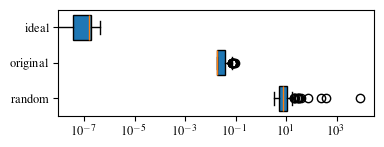

In [187]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('axes', labelsize=9)

width = 4.0
height = 1.5

fig, ax = plt.subplots()
fig.subplots_adjust(left=.2, bottom=.26, right=.99, top=.97)

all_equi = [rand_equi.tolist(), orig_equi.tolist(), ideal_equi.tolist()]
bp = plt.boxplot(all_equi, patch_artist=True, tick_labels=['random', 'original', 'ideal'], vert=False, widths=0.7)
plt.xscale('log')
fig.set_size_inches(width, height)
fig.savefig('../figs/equivariance_S5.pdf')
plt.show()

In [153]:
ideal_model = ideal_models[13]

In [154]:
submodel = model_subidx(ideal_model, irrep_idxs[13]['1d-0'])
# submodel.unembed_bias = nn.Parameter(t.zeros_like(submodel.unembed_bias))

In [134]:
equivariance(ideal_model, group)

tensor([0.0003])

In [155]:
equivariance(submodel, group)

tensor([0.0003])

In [136]:
irrep_idxs[13]

{'1d-0': [91, 111, 122],
 '4d-0': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  18,
  19,
  20,
  21,
  23,
  24,
  25,
  26,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  43,
  44,
  45,
  47,
  48,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  70,
  71,
  72,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  85,
  86,
  87,
  89,
  90,
  92,
  93,
  94,
  95,
  97,
  98,
  99,
  100,
  101,
  102,
  104,
  105,
  107,
  108,
  109,
  110,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  123,
  124,
  127],
 '5d-0': [],
 '6d-0': [],
 '5d-1': [],
 '4d-1': [],
 '1d-1': []}

In [160]:
model = models[13]
irreps, irrep_idx_dict = get_neuron_irreps(model, group, norm_thresh=0.1)
vecs, avar = get_neuron_vecs(model, group, irreps, irrep_idx_dict, strict=False, num_clusters=1, verbose=True, stab_thresh=0.3)
# irrep_acc, irrep_time, all_zeroed = irrep_acc_bound(model, group, irreps, irrep_idx_dict, vecs)
unif_vecs, zeroed_irreps = get_unif_vecs(group, irreps, vecs, verbose=True, stab_thresh=0.3)
ideal, _ = get_idealized_model(model, irreps, irrep_idx_dict, unif_vecs, verbose=True)

1d-0
1-r2 90th percentile 0.0
a variance: 0.0
b variance: 0.8888888955116272
c variance: 0.8888888955116272
d variance: 0.0
a vs d tensor(0.)
b_hat diff tensor(0.)
c_hat diff tensor(0.)
b_mean tensor([[-1.]])
c_mean tensor([[1.]])

4d-0
1-r2 90th percentile 0.049977101385593414
a variance: 0.5120246410369873
b variance: 0.9888470768928528
c variance: 0.996042013168335
d variance: 0.5120441317558289
a vs d tensor(8.9390e-06)
b_hat diff tensor(0.1062)
c_hat diff tensor(0.1062)
b_mean tensor([[-0.0112, -0.2582, -0.0610,  0.8989]])
c_mean tensor([[ 0.0093,  0.2550,  0.0618, -0.8998]])

5d-0
6d-0
5d-1
4d-1
1d-1
UNIF VECS 1d-0
coef tensor([1.1321, 1.1658, 0.0464])
unif_coef tensor([1.1490, 1.1490, 0.0000])
UNIF VECS 4d-0
4d-0 zeroed 19 106 stab 12
coef tensor([3.1721, 0.7348, 0.6512, 1.5985, 2.8507, 0.6964, 1.4886, 1.2925, 2.0700,
        0.4959, 1.9167, 1.3636, 1.4105, 1.9773, 1.9568, 0.2555, 0.6615, 0.7733,
        1.6255, 2.4068, 2.7403, 0.2055, 2.5728, 1.1255, 1.5742, 2.6145, 2.2485,
   

In [161]:
equivariance(ideal, group)

tensor([0.])

In [158]:
ideal.unembed_bias

Parameter containing:
tensor([[ 1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,
          1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,
          1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,
         -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257,
         -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257,
         -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257,
          1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,
          1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,
          1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,
         -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257,
         -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257,
         -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257,
      

In [156]:
submodel(t.tensor([[0, 0]]))

tensor([[[ 1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,
           1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257,
          -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257,
          -1.1257, -1.1257,  1.1257, -1.1257,  1.1257,  1.1257, -1.1257,
          -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257,
          -1.1257, -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,
           1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257,  1.1257,
          -1.1257, -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,
           1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,
           1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257,
          -1.1257,  1.1257, -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,
           1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257, -1.1257,
          -1.1257,  1.1257,  1.1257, -1.1257, -1.1257,  1.1257,  1.1257,
          -1.1257, -1.1257,  1.1257,  1.1257, -1.12

In [157]:
submodel(t.tensor([[15, 27]]))

tensor([[[-1.1722,  1.1722,  1.1722, -1.1722, -1.1722,  1.1722,  1.1722,
          -1.1722, -1.1722,  1.1722,  1.1722, -1.1722, -1.1722,  1.1722,
           1.1722, -1.1722, -1.1722,  1.1722,  1.1722, -1.1722, -1.1722,
           1.1722,  1.1722, -1.1722,  1.1722, -1.1722, -1.1722,  1.1722,
           1.1722, -1.1722, -1.1722,  1.1722,  1.1722, -1.1722, -1.1722,
           1.1722,  1.1722, -1.1722, -1.1722,  1.1722,  1.1722, -1.1722,
          -1.1722,  1.1722,  1.1722, -1.1722, -1.1722,  1.1722, -1.1722,
           1.1722,  1.1722, -1.1722, -1.1722,  1.1722,  1.1722, -1.1722,
          -1.1722,  1.1722,  1.1722, -1.1722, -1.1722,  1.1722,  1.1722,
          -1.1722, -1.1722,  1.1722,  1.1722, -1.1722, -1.1722,  1.1722,
           1.1722, -1.1722,  1.1722, -1.1722, -1.1722,  1.1722,  1.1722,
          -1.1722, -1.1722,  1.1722,  1.1722, -1.1722, -1.1722,  1.1722,
           1.1722, -1.1722, -1.1722,  1.1722,  1.1722, -1.1722, -1.1722,
           1.1722,  1.1722, -1.1722, -1.1722,  1.17

In [10]:
test_inputs = t.tensor(list(product(range(data.N), repeat=2)), device=device)
models[0](test_inputs).shape

torch.Size([14400, 1, 120])

In [13]:
data.groups[0].mult_idx(0, 0)

0

In [14]:
test_inputs[:10]

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [0, 5],
        [0, 6],
        [0, 7],
        [0, 8],
        [0, 9]])